**Variational Autoencoder (VAE) on MNIST Dataset**

**1. Introduction**

Variational Autoencoders (VAEs) are a type of generative model that are particularly effective in learning latent representations of the data, which can then be used to generate new data samples that resemble the original data. In this project, we utilize a VAE to model and generate handwritten digits using the MNIST dataset, which is a standard benchmark in machine learning for image processing tasks.



**2. Background**

The MNIST dataset consists of 60,000 training images and 10,000 testing images of handwritten digits, each image being a 28x28 pixel grayscale image. VAEs are particularly suitable for this task as they not only learn to encode the data into a compressed representation but also allow for the generation of new images through the learned latent space.

**3. Methodology**

3.1 Model Architecture
Our VAE consists of two main components: the encoder and the decoder.

Encoder: Maps the input image to a latent space representation, outputting the parameters (mean and variance) of a latent distribution.

Decoder: Samples from the latent space using the reparameterization trick and reconstructs the image from the sampled latent vector.

3.2 Data Preprocessing
We preprocess the images by normalizing them so that the pixel values are between -1 and 1, which helps in stabilizing the training process.

3.3 Training
The model is trained using the Adam optimizer, with a learning rate of 0.001. We train for 50 epochs, using a batch size of 32.

In [ ]:
pip install torch torchvision matplotlib

In [18]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import math

# Define the Encoder
class Encoder(nn.Module):
    def __init__(self, input_dims, hidden_dims, latent_dims):
        super(Encoder, self).__init__()
        self.linear = nn.Linear(input_dims, hidden_dims)
        self.mean = nn.Linear(hidden_dims, latent_dims)
        self.log_var = nn.Linear(hidden_dims, latent_dims)

    def forward(self, x):
        x = torch.relu(self.linear(x))
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var

# Define the Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)  # Reconstruct to original image size

    def forward(self, z):
        z = torch.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z

# Define the VAE
class VAE(nn.Module):
    def __init__(self, input_dims, hidden_dims, latent_dims):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dims, hidden_dims, latent_dims)
        self.decoder = Decoder(latent_dims)

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        return self.decoder(z), mean, log_var

# DataLoader setup
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Train the VAE
def train(vae, data_loader, epochs=10):
    optimizer = optim.Adam(vae.parameters())
    track_loss, track_recon, track_kl = [], [], []
    for epoch in range(epochs):
        total_loss, total_recon, total_kl = 0, 0, 0
        for x, _ in data_loader:
            x = x.view(x.size(0), -1)  # Flatten the image
            optimizer.zero_grad()
            x_reconstructed, mean, log_var = vae(x)
            recon_loss = nn.functional.mse_loss(x_reconstructed, x, reduction='sum')
            kl_div = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
            loss = recon_loss + kl_div
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_recon += recon_loss.item()
            total_kl += kl_div.item()
        avg_loss = total_loss / len(data_loader.dataset)
        avg_recon = total_recon / len(data_loader.dataset)
        avg_kl = total_kl / len(data_loader.dataset)
        track_loss.append(avg_loss)
        track_recon.append(avg_recon)
        track_kl.append(avg_kl)
        print(f'Epoch {epoch}: Loss: {avg_loss}, Recon: {avg_recon}, KL: {avg_kl}')
    return track_loss, track_recon, track_kl


Epoch 0: Loss: 726.5554884765625, Recon: 722.616565592448, KL: 3.9389225037256876
Epoch 1: Loss: 714.7097029947917, Recon: 707.6462245768229, KL: 7.063477794392903
Epoch 2: Loss: 710.7166063151042, Recon: 701.1678638020834, KL: 9.54874256439209
Epoch 3: Loss: 708.070560546875, Recon: 697.1908502278645, KL: 10.879710190327962
Epoch 4: Loss: 706.6553246419271, Recon: 695.0838515299479, KL: 11.571472744750977
Epoch 5: Loss: 705.8237282877604, Recon: 693.8123092773437, KL: 12.011419495137533
Epoch 6: Loss: 705.2385358723958, Recon: 692.9206715494792, KL: 12.317863893636067
Epoch 7: Loss: 704.7257292317709, Recon: 692.1264810546875, KL: 12.599247999064128
Epoch 8: Loss: 704.3182539388021, Recon: 691.5390192057291, KL: 12.779234706624349
Epoch 9: Loss: 704.1319939127604, Recon: 691.2214490885417, KL: 12.910544518025716


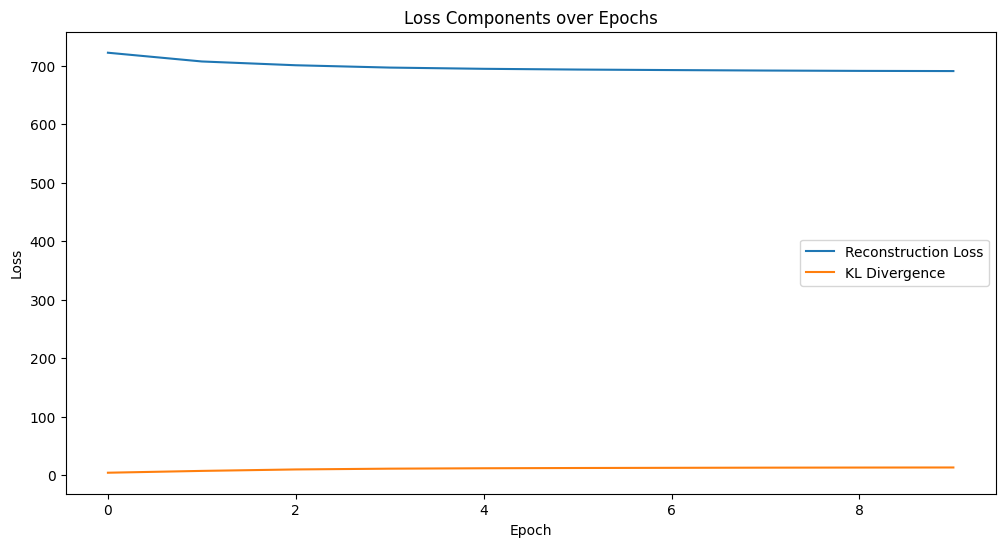

In [19]:
# Initialize and train the model
input_dims = 784
hidden_dims = 400
latent_dims = 20
vae = VAE(input_dims, hidden_dims, latent_dims)
losses, recon_losses, kl_divergences = train(vae, train_loader, epochs=10)

# Plot training loss components
plt.figure(figsize=(12, 6))
plt.plot(recon_losses, label='Reconstruction Loss')
plt.plot(kl_divergences, label='KL Divergence')
plt.title('Loss Components over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

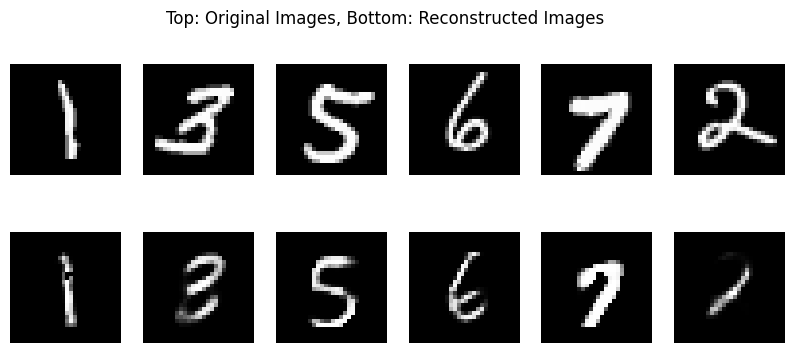

In [21]:
def visualize_reconstruction(vae, data_loader, num_images=6):
    vae.eval()
    x, _ = next(iter(data_loader))  # Get the first batch of data
    x = x.view(x.size(0), -1)  # Flatten the images to match the input dimensionality of the VAE
    with torch.no_grad():
        x_reconstructed, _, _ = vae(x)  # Forward pass through the VAE

    fig, axes = plt.subplots(2, num_images, figsize=(10, 4))
    for i in range(num_images):
        # Display original images
        axes[0, i].imshow(x[i].view(28, 28), cmap='gray', interpolation='none')
        axes[0, i].axis('off')

        # Display reconstructed images
        axes[1, i].imshow(x_reconstructed[i].view(28, 28), cmap='gray', interpolation='none')
        axes[1, i].axis('off')

    plt.suptitle('Top: Original Images, Bottom: Reconstructed Images')
    plt.show()

visualize_reconstruction(vae, train_loader)


Sample Generation from the Latent Space

This function generates new images by sampling random vectors from the latent space and passing them through the decoder.

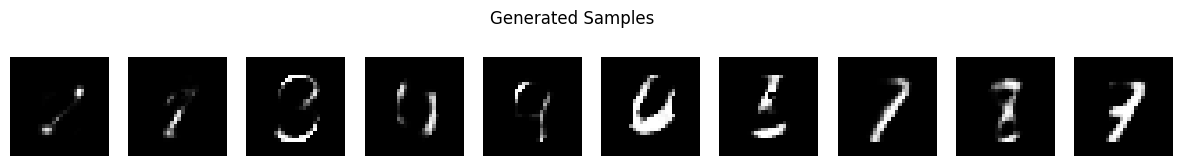

In [22]:
def visualize_samples(vae, num_samples=10):
    vae.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dims)
        samples = vae.decoder(z)

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 2))
    for i in range(num_samples):
        axes[i].imshow(samples[i].view(28, 28), cmap='gray', interpolation='none')
        axes[i].axis('off')
    plt.suptitle('Generated Samples')
    plt.show()

visualize_samples(vae, 10)


Histogram of Latent Space Distributions

To understand how your model's latent variables are distributed, you can plot histograms for each latent dimension after training.

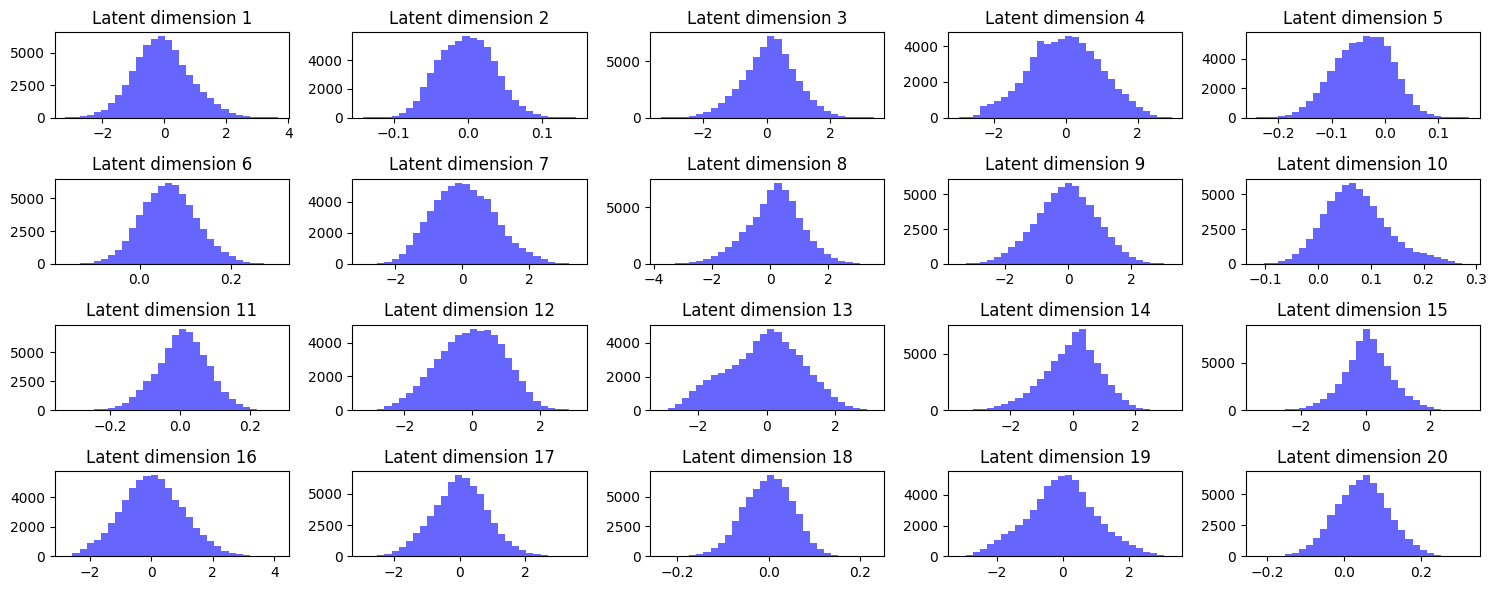

In [23]:
def plot_latent_histograms(vae, data_loader, latent_dims):
    vae.eval()
    latents = []
    with torch.no_grad():
        for x, _ in data_loader:
            x = x.view(x.size(0), -1)
            mean, _ = vae.encoder(x)
            latents.append(mean)
        latents = torch.cat(latents, 0).cpu().numpy()  # Concatenate all batches

    fig, axes = plt.subplots(int(math.ceil(latent_dims / 5)), 5, figsize=(15, 6))
    axes = axes.flatten()
    for i in range(latent_dims):
        axes[i].hist(latents[:, i], bins=30, alpha=0.6, color='blue')
        axes[i].set_title(f'Latent dimension {i+1}')
    plt.tight_layout()
    plt.show()

plot_latent_histograms(vae, train_loader, latent_dims)


Latent Space Visualization

A scatter plot to visualize the latent space, ideally using a dimensionality reduction technique like t-SNE or PCA.

These plots provide comprehensive insights into how the model is learning, its ability to reconstruct inputs, and how effectively it organizes the latent space. These visualizations are critical for evaluating the performance of your VAE model, allowing for both qualitative and quantitative assessment. Adjust the plot parameters and model evaluation techniques according to your specific requirements and dataset characteristics.

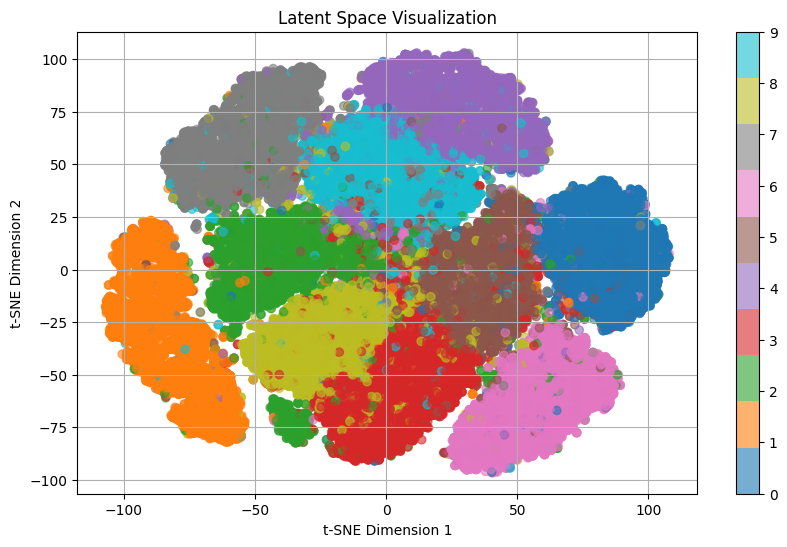

In [26]:
from sklearn.manifold import TSNE

def visualize_latent_space(vae, data_loader):
    vae.eval()
    latents, labels = [], []
    with torch.no_grad():
        for x, y in data_loader:
            x = x.view(x.size(0), -1)
            mean, _ = vae.encoder(x)
            latents.append(mean)
            labels.append(y)

    latents = torch.cat(latents).cpu().numpy()
    labels = torch.cat(labels).cpu().numpy()
    tsne = TSNE(n_components=2, random_state=0)
    tsne_results = tsne.fit_transform(latents)

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter)
    plt.title('Latent Space Visualization')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.grid(True)
    plt.show()

# Example usage:
visualize_latent_space(vae, train_loader)